In [67]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math

#Basic concept

Given 2 points:
$p_1 = (x_0, y_0), p_2 = (x_1, y_1)$, the linear interpolant is the straight line between 2 points.

That means, for all values x in interval ($x_0,x_1$), the value y along the straight line is given from the equation of slopes
$\frac{y-y_0}{x-x_0} = \frac{y_1-y_0}{x_1-x_0}$, and we can interpolate y with a given x as folow:
$y = y_0\frac{x_1-x}{x_1-x_0} + y_1\frac{x-x_0}{x_1-x_0}$

In [68]:
def linear_interpolation(p1, p2, x):
  #get location of each pixel
  x0, y0 = p1
  x1, y1 = p2
  if x0 != x1: #interpolate y with a given x
      y = ((x1-x)/(x1-x0))*y0 + ((x-x0)/(x1-x0))*y1
  else:
      y = y0 #because of linear interpolation, if x1 == x2 => y2 = y1
  return y

In [69]:
p1 = (1,1)
p2 = (3,3)
x = 2
y = linear_interpolation(p1=p1, p2=p2, x=x)
print(f"linear interpolation p1={p1}, p2={p2}, with given x={x}, we have y={y}")

linear interpolation p1=(1, 1), p2=(3, 3), with given x=2, we have y=2.0


#Find null values and interpolate it

In [70]:
class interpolate_Nullvar():
  def __init__(self, data):
    self._data = data

  #Find the index of a null value
  def find_nullvar_index(self):
    index = -1
    for i, v in enumerate(self._data):
      if v== None:
        index = i
        break
    return index

  #Find the index of the not-null value after a null value
  def find_nextnotnullvar_index(self, index):
    end_index = len(self._data)
    for i in range(index+1, len(self._data), 1):
      if self._data[i] != None:
          end_index = i
          break
    return end_index

  def linear_interpolation(self, p1, p2, x):
    x1, y1 = p1
    x2, y2 = p2
    if x1 != x2:
      y = ((x2-x)/(x2-x1))*y1 + ((x-x1)/(x2-x1))*y2
    else:
      y = y1
    return y

  #Find null values and interpolate it
  def interpolate(self):
    while True:
      index = self.find_nullvar_index()
      if index == -1:
        break
      #find interval (x_0, x_1) of null value (x)
      begin_index = index - 1 #x_0
      end_index = self.find_nextnotnullvar_index(index) #x_1
      if begin_index < 0: #x_0 < 0 => x = y1
        y = self._data[end_index]
      elif end_index >= len(self._data): #x_1 >= len(data) => x = y0
        y = self._data[begin_index]
      else: #x in interval (x_0, x_1) => interpolate y with given x
        p1 = (begin_index, self._data[begin_index])
        p2 = (end_index, self._data[end_index])
        y = self.linear_interpolation(p1, p2, index)
      self._data[index] = y #fill null value with interpolated value
    return self._data

In [71]:
# test
data = [None, 2.2, 2.0, 2.2, None, None, None, 2.7, None, 4.9, None]
print(f'data: {data}')
result = interpolate_Nullvar(data).interpolate()
print(f'result: {result}')

data: [None, 2.2, 2.0, 2.2, None, None, None, 2.7, None, 4.9, None]
result: [2.2, 2.2, 2.0, 2.2, 2.325, 2.45, 2.575, 2.7, 3.8000000000000003, 4.9, 4.9]


#Resize the image

(500, 1200)


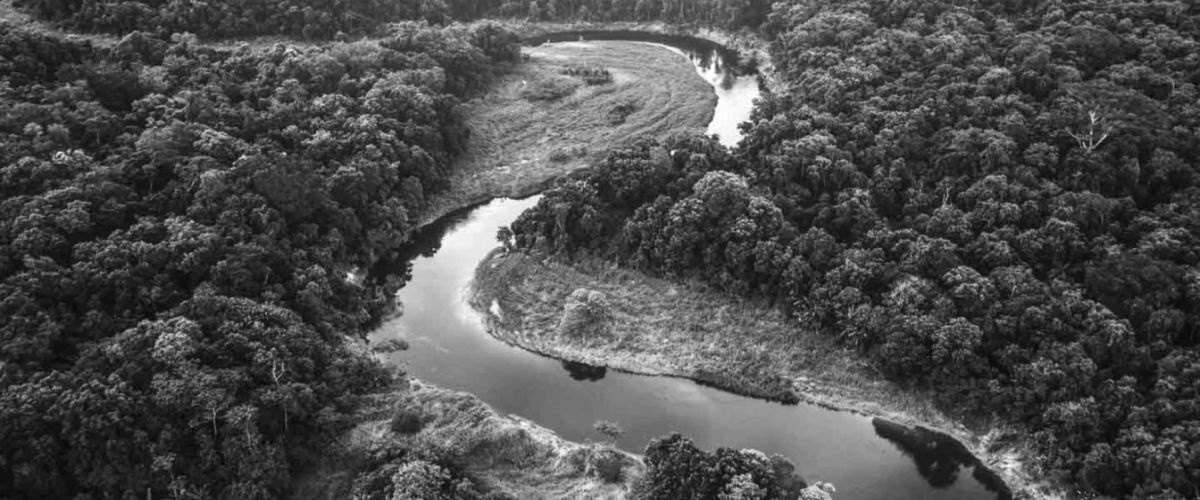

In [72]:
#Show the original image
img = cv2.imread('nature.jpg', 0)
print(img.shape)
cv2_imshow(img)

##Resize the image without using linear interpolation (2 steps).

In [73]:
def sim_resize(data, h_scale_factor=0.5, w_scale_factor=0.5):
  #data preparation
  source = np.array(data)
  source_h = source.shape[0]
  source_w = source.shape[1]
  target_w = round(source_w*w_scale_factor)
  target_h = round(source_h*h_scale_factor)

  # step 1: interpolating for each row
  new_data_1 = [[0]*target_w for _ in range(source_h)] #creating new image (source_h, target_w)'
  for i in range(source_h):
    for j in range(target_w):
      if w_scale_factor < 1:
        j_scaled = round(j//(1/w_scale_factor))
      else:
        j_scaled = j//w_scale_factor
      new_data_1[i][j] = source[i][j_scaled] #repeating original value => new value

  # step 2: interpolating for each column
  new_data_2 = [[0]*target_w for _ in range(target_h)] #creating new image (target_h, target_w)
  for j in range(target_w):
    for i in range(target_h):
      if w_scale_factor < 1:
        i_scaled = round(i//(1/h_scale_factor))
      else:
        i_scaled = i//h_scale_factor
      new_data_2[i][j] = new_data_1[i_scaled][j] #repeating original value => new value
  return new_data_2

(250, 600)


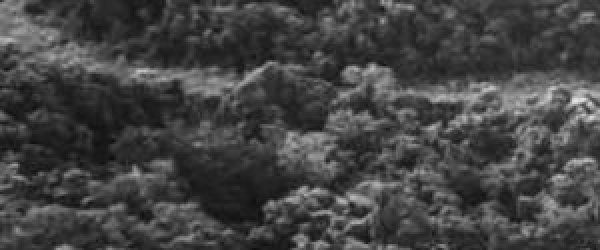

In [74]:
new_img = sim_resize(img, h_scale_factor = 0.5, w_scale_factor = 0.5)
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

(1000, 2400)


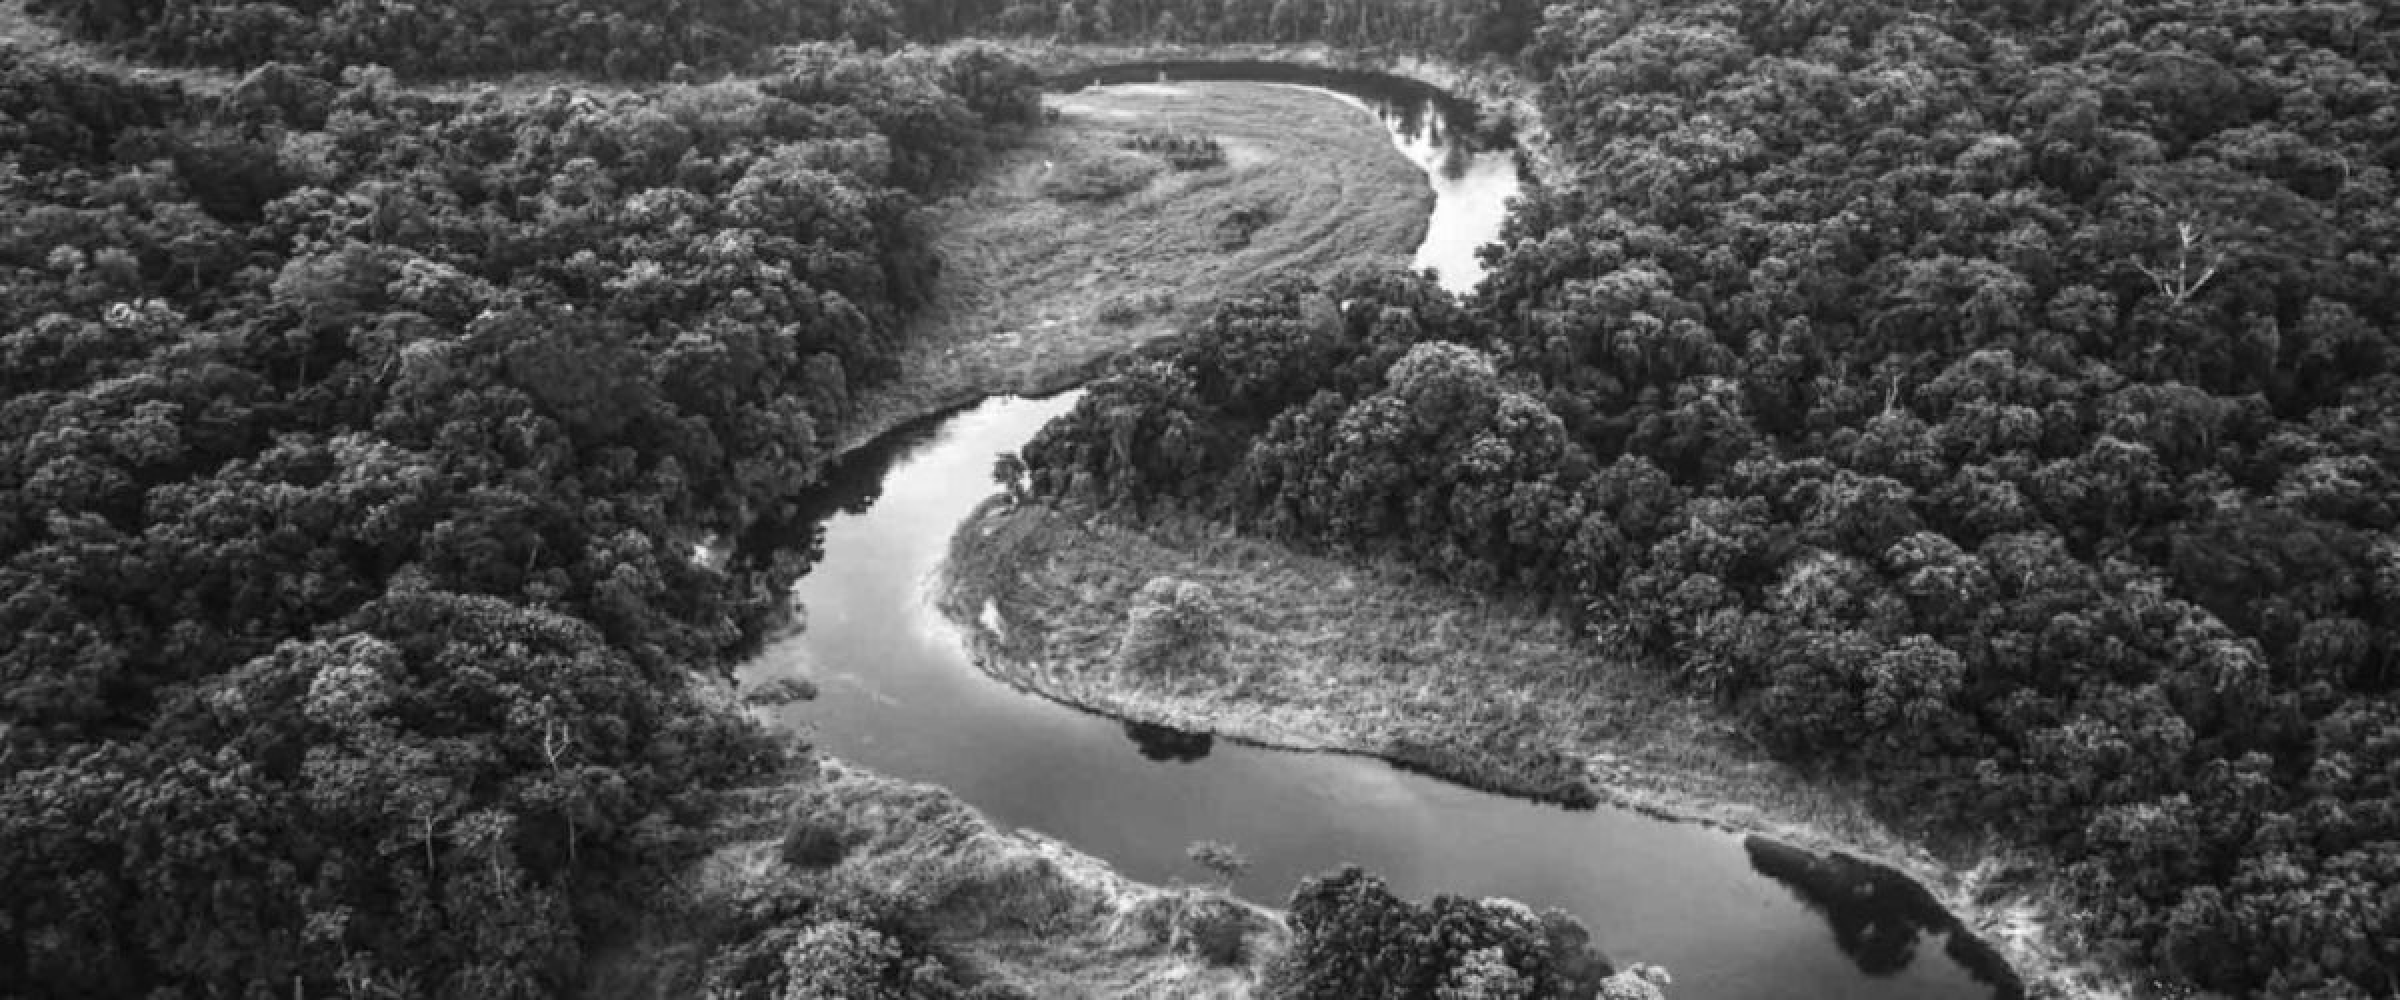

In [75]:
new_img = sim_resize(img, h_scale_factor = 2, w_scale_factor = 2)
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

##Resize image using linear interpolation (2 steps).

In [76]:
def linear_interpolate(data, w_scale_factor = 0.5, h_scale_factor = 0.5):
  #data preparation
  source = np.array(data)
  source_h = len(source)
  source_w = len(source[0])
  target_w = round(source_w*w_scale_factor)
  target_h = round(source_h*h_scale_factor)

  # step 1: interpolating for each row
  new_data_1 = [[0]*target_w for _ in range(source_h)] #creating new image (source_h, target_w)
  for i in range(source_h):
    # get each row of original image
    data = source[i]
    # get each value in this row
    for j in range(target_w-1):
      if w_scale_factor <= 0:
        col = j%(1/w_scale_factor)
        col_ = j//(1/w_scale_factor)
      else:
        col = j%w_scale_factor
        col_ = j//w_scale_factor
      if round(col) == 0:
        j_scaled = round(col_)
        new_data_1[i][j] = data[j_scaled] #fill with original values
      else:
        x1 = math.floor(j/w_scale_factor)
        p1 = (x1, data[x1]) #idx of original value above, original value above
        x2 = math.ceil(j/w_scale_factor)
        p2 = (x2, data[x2]) #idx of original value below, original value below
        x = j/w_scale_factor
        new_data_1[i][j] = linear_interpolation(p1, p2, x) #interpolate null values using their adjacent original values

  # step 2: interpolating for each column
  new_data_2 = [[0]*target_w for _ in range(target_h)] #creating new image (target_h, target_w)
  for j in range(target_w):
      # get each column of the image which is interpolated by row
      data = [row[j] for row in new_data_1]
      #get each value in this column
      for i in range(target_h-1):
        if w_scale_factor <= 0:
          row = i%(1/h_scale_factor)
          row_ = i//(1/h_scale_factor)
        else:
          row = i%h_scale_factor
          row_ = i//h_scale_factor
        if round(row) == 0:
            i_scaled = round(row_)
            new_data_2[i][j] = data[i_scaled] #fill with original values
        else:
            x1 = math.floor(i/h_scale_factor)
            p1 = (x1, data[x1]) #idx of original value on the left,  original value on the left
            x2 = math.ceil(i/h_scale_factor)
            p2 = (x2, data[x2]) #idx of original value on the right, original value on the right
            x = i/w_scale_factor
            new_data_2[i][j] = linear_interpolation(p1, p2, x) #interpolate null values using their adjacent original values

  return new_data_2

(250, 600)


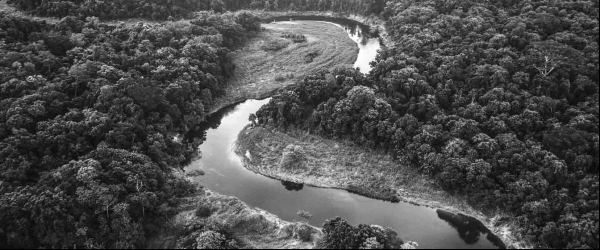

In [77]:
new_img = linear_interpolate(img, w_scale_factor = 0.5, h_scale_factor = 0.5)
# read image
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

(1000, 2400)


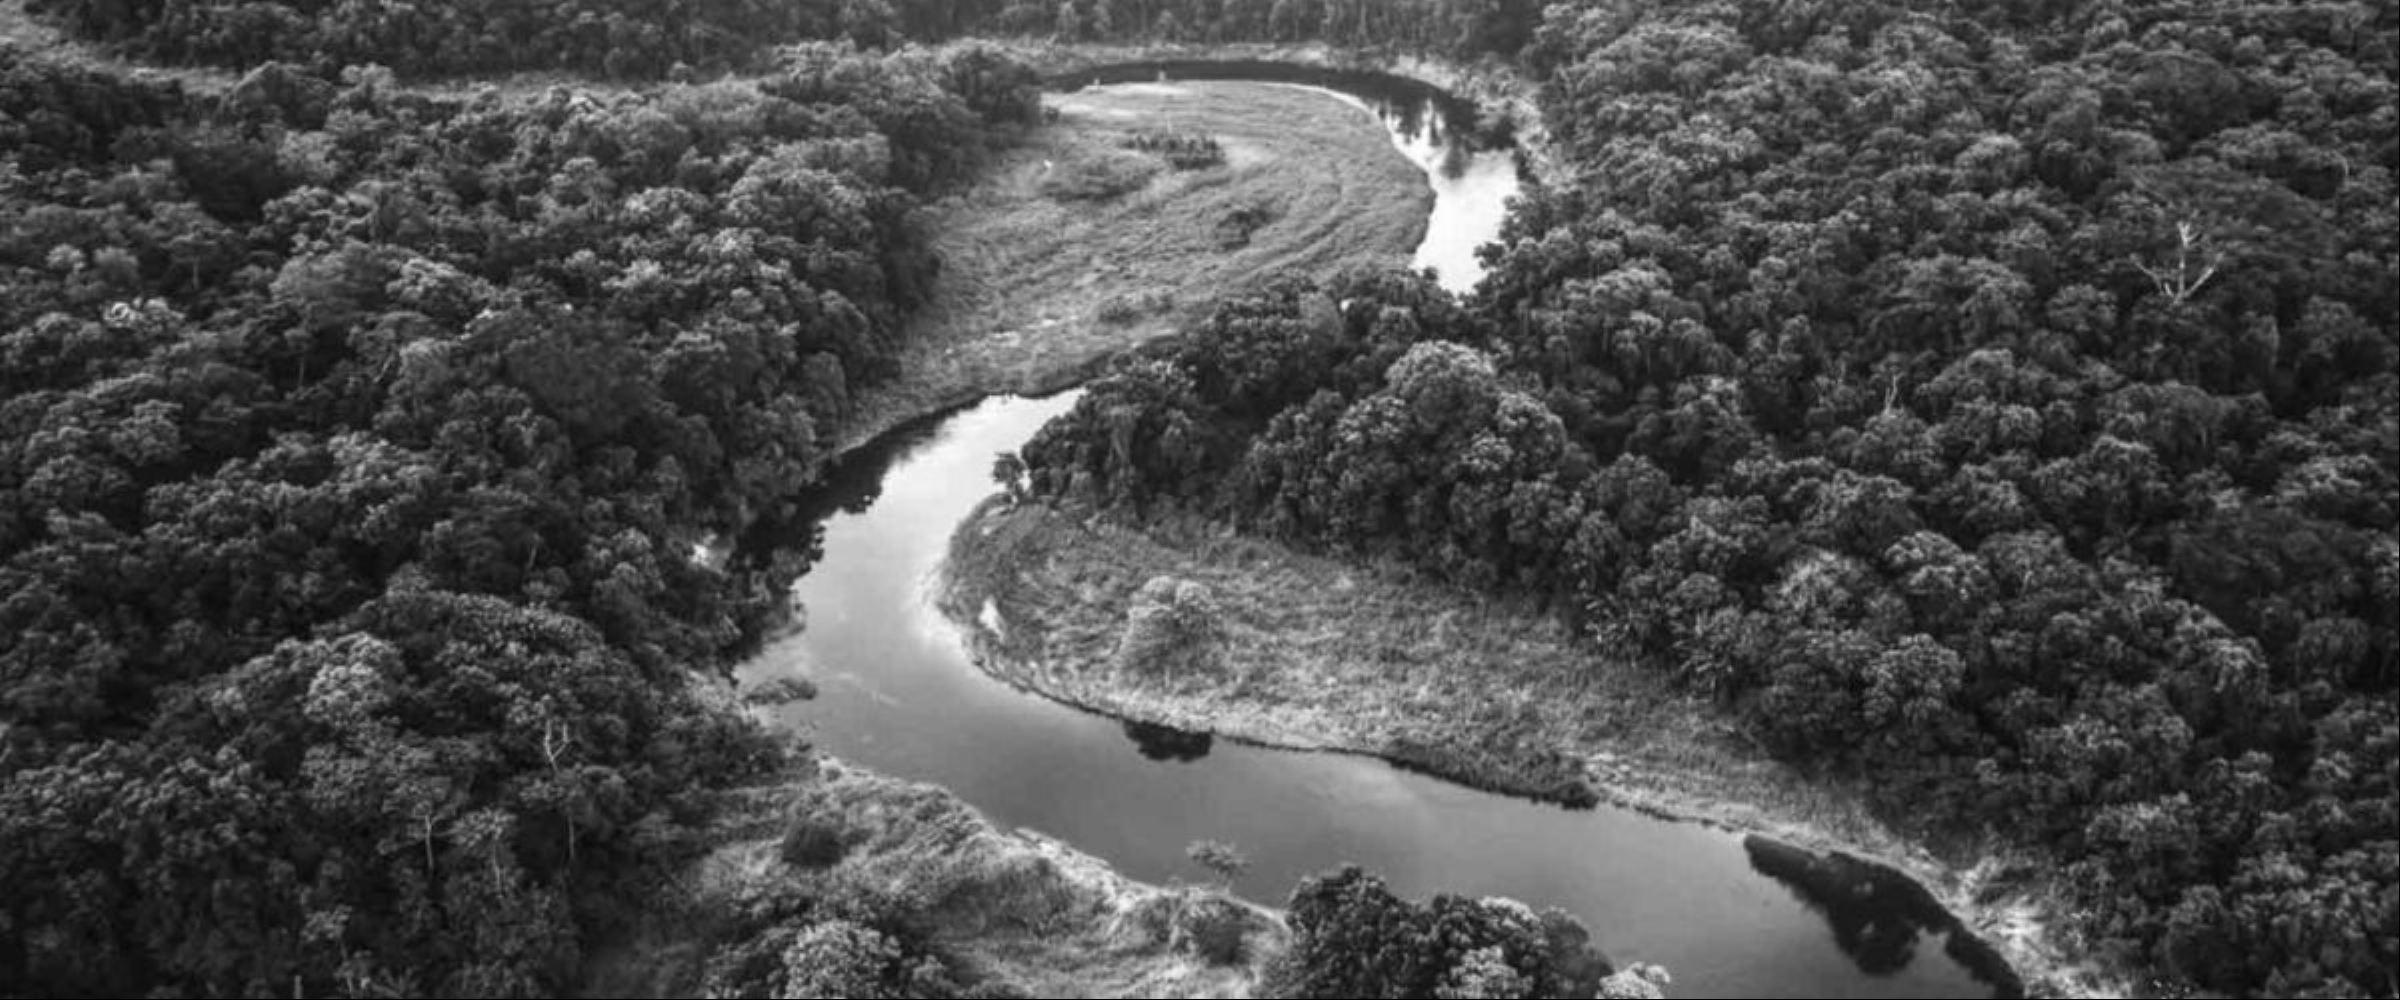

In [78]:
new_img = linear_interpolate(img, w_scale_factor = 2, h_scale_factor = 2)
# read image
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

# save image
#cv2.imwrite('nature_linear_interpolation.png', np.array(new_img))

JPG is a lossy compressed file format

PNG is a lossless compressed file format

##Resize image using the mean of neighbour pixel cluster (1 step).

In [79]:
def neighbor_cluster_resize(data, w_scale_factor = 0.5, h_scale_factor = 0.5):
  #data preparation
  source = np.array(data)
  source_h = len(source)
  source_w = len(source[0])
  target_w = round(source_w*w_scale_factor)
  target_h = round(source_h*h_scale_factor)

  #creating new image (target_h, target_w)
  new_image = [[[]*j for j in range(target_w)] for i in range(target_h)]

  #Because of cropping, 1 pixel will be the mean of its neighbor pixel cluster.
  #get its neighbor pixel cluster for each pixel in new image
  details  = []
  for hei in range(source_h):
    for wid in range(source_w):
      details.append([math.floor(hei*h_scale_factor),math.floor(wid*w_scale_factor),source[hei][wid]])
  for k in details:
    new_image[k[0]][k[1]].append(k[2])

  #fill each pixel of new image with mean of its neighbor pixel cluster
  for _i in range(len(new_image)):
    for _j in range(len(new_image[0])):
      new_image[_i][_j] = np.mean(new_image[_i][_j])

  return new_image

(250, 600)


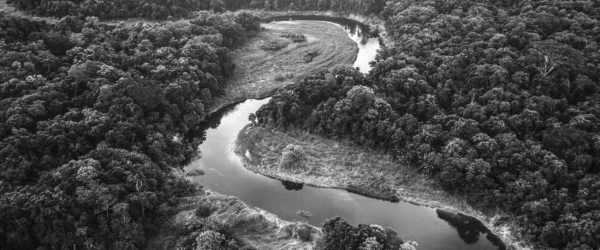

In [80]:
new_img = neighbor_cluster_resize(img, w_scale_factor = 0.5, h_scale_factor = 0.5)
# read image
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

(1000, 2400)


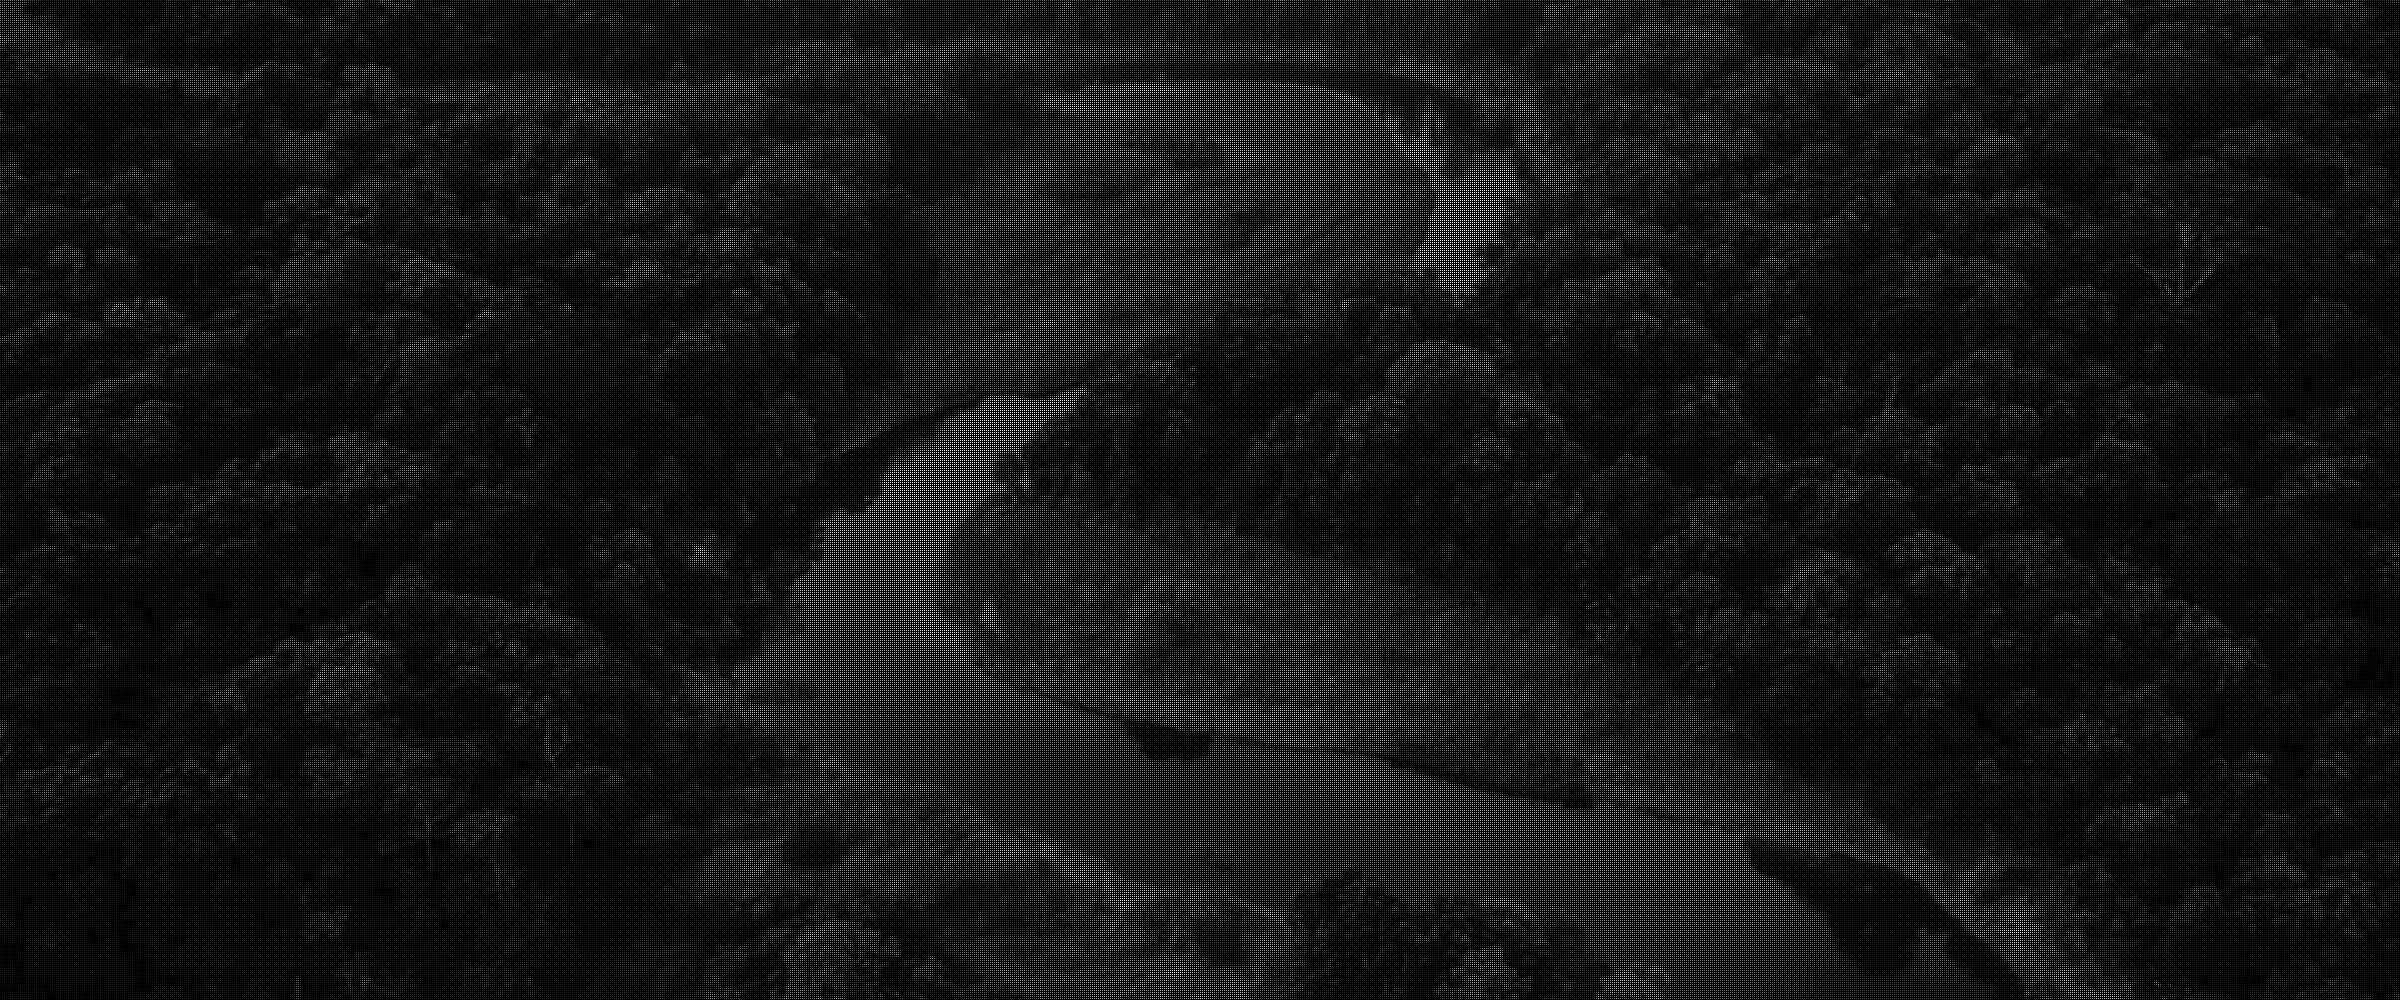

In [81]:
new_img = neighbor_cluster_resize(img, w_scale_factor = 2, h_scale_factor = 2)
# read image
print(np.array(new_img).shape)
cv2_imshow(np.array(new_img))

##Using build-in Functions in OpenCV

(250, 600)


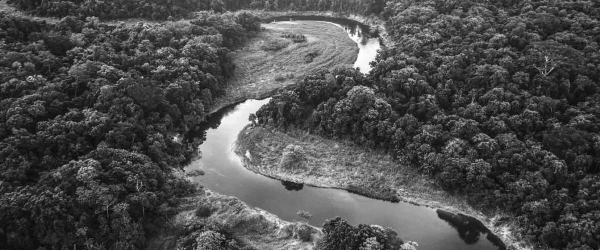

In [82]:
height, width = img.shape
new_dim = (round(width*0.5), round(height*0.5))
new_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_NEAREST)
print(new_img.shape)
cv2_imshow(new_img)

(1000, 2400)


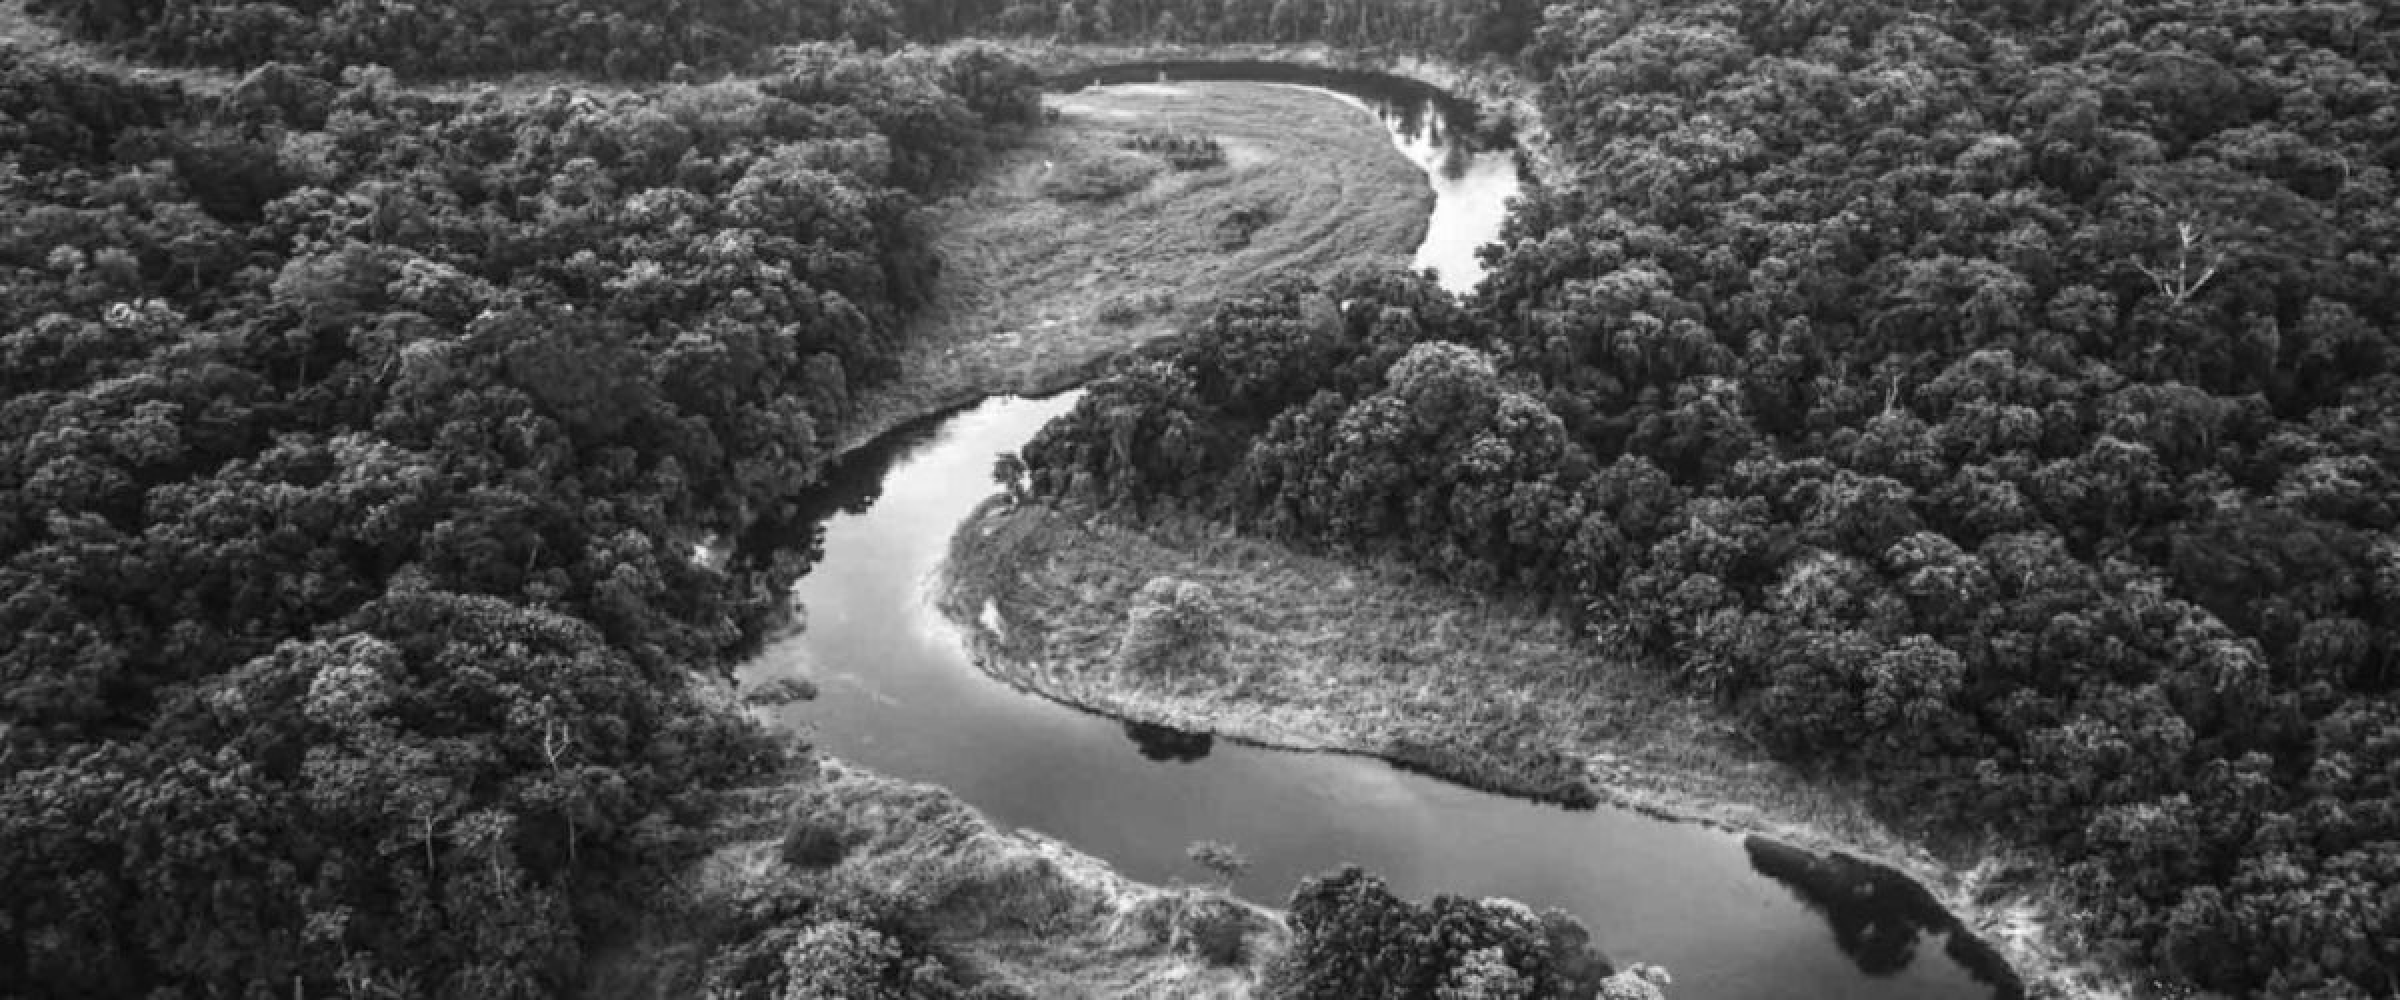

In [83]:
height, width = img.shape
new_dim = (round(width*2), round(height*2))
new_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_NEAREST)
print(new_img.shape)
cv2_imshow(new_img)

(250, 600)


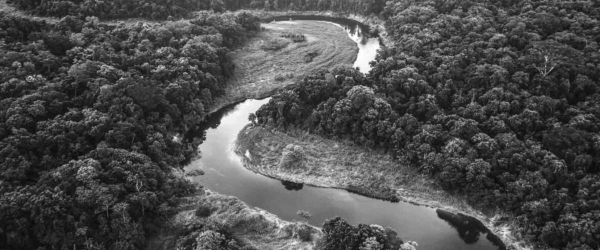

In [ ]:
height, width = img.shape
new_dim = (round(width*0.5), round(height*0.5))
new_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)
print(new_img.shape)
cv2_imshow(new_img)

(1000, 2400)


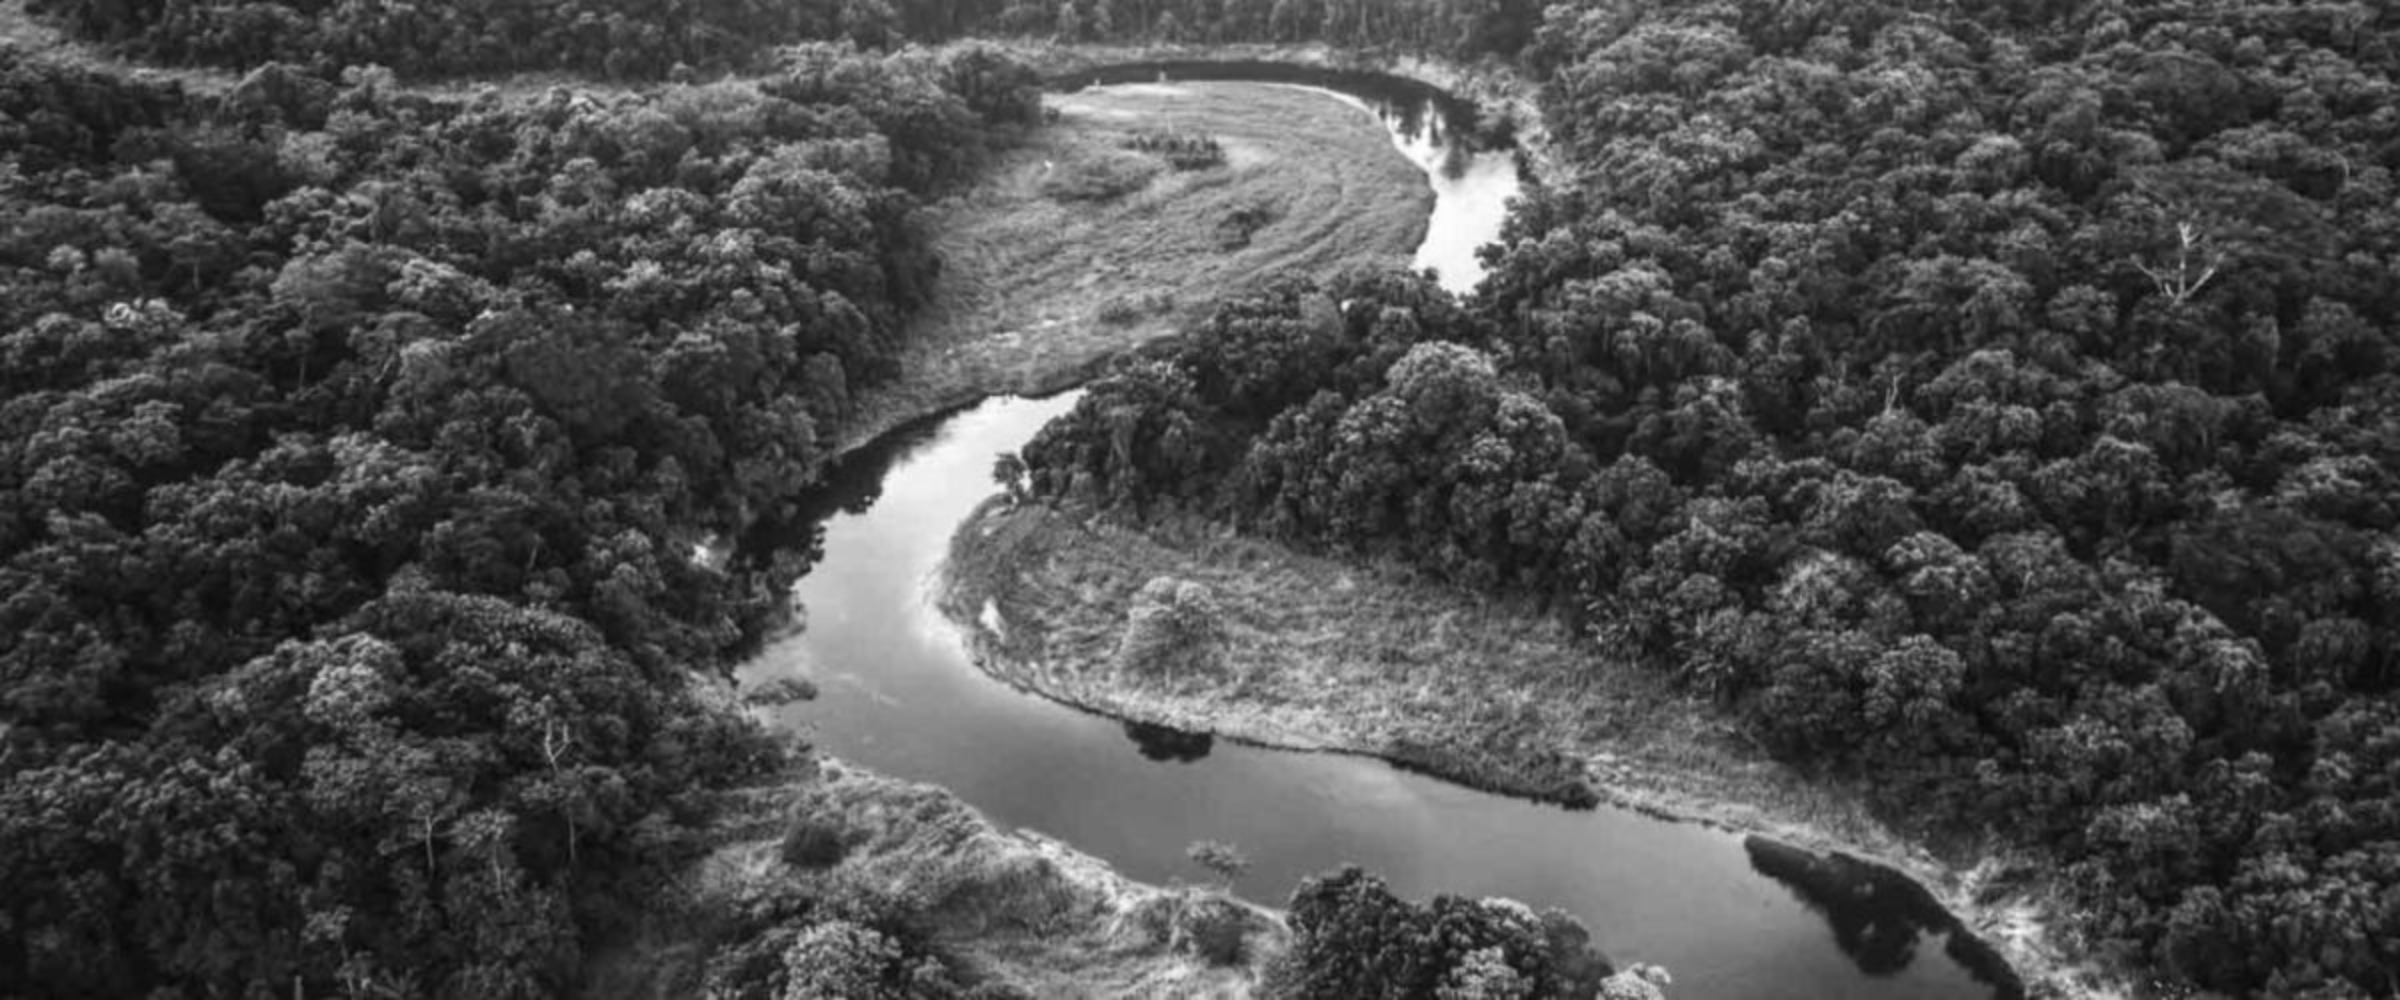

In [ ]:
height, width = img.shape
new_dim = (round(width*2), round(height*2))
new_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)
print(new_img.shape)
cv2_imshow(new_img)